<title>Intro to Data Science by Blueprint</title>

<h1>Intro to Data Science by Blueprint</h1>


<h2>Import Libraries</h2>

In [1]:
# Ignore all warnings because we live dangerously like that
import warnings
warnings.filterwarnings('ignore')

import itertools # Iteration tools
import matplotlib.pyplot as plt # plotting library
import numpy as np # linear algebra, number processing
import pandas as pd # data processing, data frames. CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm # statistic models i.e. linear regression
import geopandas as gpd # data processing with geospatial data
from geopandas.plotting import (plot_linestring, plot_point, norm_cmap) # Plotting geospatial data

# Bokeh is a visualization library that leverages JS and is similar to D3.js
from bokeh.io import show, output_notebook, push_notebook 
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool

from collections import defaultdict

# Additional imports for matplotlib
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import cm
from sklearn import preprocessing # data preprocessing

<h2>Set up Notebook</h2>

In [2]:
# Show matplotlib plots in this notebook
%matplotlib inline
# Show bokeh plots in this notebook
output_notebook()

# Setting plot parameters
from pylab import rcParams
params = {
    'figure.figsize': (16, 10),
    'legend.fontsize': 15
}
rcParams.update(params)

Loading BokehJS ...

<h2>Define Helper Functions</h2>

In [3]:
def plot_polygon(ax, poly, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Plot a single Polygon geometry """
    from descartes.patch import PolygonPatch
    a = np.asarray(poly.exterior)
    # without Descartes, we could make a Patch of exterior
    ax.add_patch(PolygonPatch(poly, facecolor=facecolor, alpha=alpha))
    ax.plot(a[:, 0], a[:, 1], color=edgecolor, linewidth=linewidth)
    for p in poly.interiors:
        x, y = zip(*p.coords)
        ax.plot(x, y, color=edgecolor, linewidth=linewidth)

def plot_multipolygon(ax, geom, facecolor='red', edgecolor='black', alpha=0.5, linewidth=1):
    """ Can safely call with either Polygon or Multipolygon geometry
    """
    if geom.type == 'Polygon':
        plot_polygon(ax, geom, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)
    elif geom.type == 'MultiPolygon':
        for poly in geom.geoms:
            plot_polygon(ax, poly, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=linewidth)


def plot_geodataframe(s, column=None, colormap=None, alpha=0.5,
                   categorical=False, legend=False, axes=None, linewidth=1):
    """ Plot a GeoDataFrame

        Generate a plot of a GeoDataFrame with matplotlib.  If a
        column is specified, the plot coloring will be based on values
        in that column.  Otherwise, a categorical plot of the
        geometries in the `geometry` column will be generated.

        Parameters
        ----------

        GeoDataFrame
            The GeoDataFrame to be plotted.  Currently Polygon,
            MultiPolygon, LineString, MultiLineString and Point
            geometries can be plotted.

        column : str (default None)
            The name of the column to be plotted.

        colormap : str (default 'Set1')
            The name of a colormap recognized by matplotlib.

        alpha : float (default 0.5)
            Alpha value for polygon fill regions.  Has no effect for
            lines or points.

        legend : bool (default False)
            Plot a legend (Experimental; currently for categorical
            plots only)

        axes : matplotlib.pyplot.Artist (default None)
            axes on which to draw the plot


        Returns
        -------

        matplotlib axes instance
    """
    
    if colormap is None:
        colormap = 'Set1'
    categories = list(set(s[column].values))
    categories.sort()
    valuemap = dict([(k, v) for (v, k) in enumerate(categories)])
    values = [valuemap[k] for k in s[column]]

    cmap = norm_cmap(values, colormap, Normalize, cm)
    if axes == None:
        fig = plt.gcf()
        fig.add_subplot(111, aspect='equal')
        ax = plt.gca()
    else:
        ax = axes
    for geom, value in zip(s.geometry, values):
        if geom.type == 'Polygon' or geom.type == 'MultiPolygon':
            plot_multipolygon(ax, geom, facecolor=cmap.to_rgba(value), alpha=alpha, linewidth=linewidth)
        elif geom.type == 'LineString' or geom.type == 'MultiLineString':
            plot_multilinestring(ax, geom, color=cmap.to_rgba(value))
        elif geom.type == 'Point':
            plot_point(ax, geom, color=cmap.to_rgba(value))
    if legend:
        patches = []
        size = len(categories)
        # Legend shows the min, 25th, 50th, 75th and max values
        indices = [0, size / 4, size / 2, size / 4 * 3, size - 1]
        categories = [categories[i] for i in indices]
        for value, cat in zip(indices, categories):
            patches.append(Line2D([0], [0], linestyle="none",
                                  marker="o", alpha=alpha,
                                  markersize=15, markerfacecolor=cmap.to_rgba(value)))
        ax.legend(patches, categories, numpoints=1, loc='best')

    return ax

In [4]:
def plot_world_happiness_by_continent(world_happiness_df):
    p = figure(plot_width=600, plot_height=400, tools=['pan' ,'box_zoom','reset', 'wheel_zoom'],
           title="Happiness vs GDP")
    colors = itertools.cycle(["#3366cc", "#dc3912", "#ff9900", "#109618", "#990099", "#0099c6", "#dd4477", "#66aa00", "#b82e2e", "#316395", "#994499", "#22aa99", "#aaaa11", "#6633cc", "#e67300", "#8b0707", "#651067", "#329262", "#5574a6", "#3b3eac"])
    for continent in list(set(world_happiness_df.continent)):
        t = (world_happiness_df
             .drop('geometry', axis=1)
             .rename(columns={'Happiness Score': 'happiness_score'}))
        t = t.loc[t['continent'] == continent]
        p.circle(t['Economy (GDP per Capita)'], t['happiness_score'], legend=continent, fill_color=colors.next(), size=10)
    show(p)
    
def create_hover_tool():
    return HoverTool(tooltips=[
        ("Country", "@Country"),
        ("Happiness Score", "@happiness_score"),
        ("GDP Per Capita", "@gdp_per_cap"),
        ("Continent", "@continent"),
        ("Region", "@Region"),
    ])

def process_dataframe_for_bokeh(df):
    return df.drop('geometry', axis=1).rename(columns={'Happiness Score': 'happiness_score'})

<h2>Initial Exploration</h2>

In [5]:
# Read in the data
df = pd.read_csv('data/2016.csv')

In [6]:
# Show the first 5 rows
df.head()

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


<h2>Determining Important Features</h2>

In [7]:
# Keep columns that come after the 6th column (including the 6th)
X = df.iloc[:,6:]
# Retrieve a single column of the hapinness score
y = df['Happiness Score']

In [8]:
X.head()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


In [9]:
y[:5]

0    7.526
1    7.509
2    7.501
3    7.498
4    7.413
Name: Happiness Score, dtype: float64

In [10]:
# Normalize values to be in between 0 and 1
scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = scaler.fit_transform(y.reshape(-1, 1))

In [11]:
X.head()

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,0.790333,0.983503,0.834451,0.952225,0.879892,0.441266,0.636294
1,0.837228,0.967868,0.905811,0.962349,0.815562,0.342597,0.621472
2,0.782044,1.000000,0.910325,0.930581,0.296411,0.581645,0.666753
3,0.864697,0.952369,0.835238,0.979638,0.708141,0.462298,0.611544
4,0.770708,0.958910,0.851108,0.938470,0.811623,0.310988,0.664961


In [12]:
# Run Linear regression using the ordinary least squares methods
# which minimizes the error between each point and our line
# F-statistic looks how well the model fits to the data (above 0.05 we reject we have 2.33e-112 so it fits)
# R-Squared in genearl points to good fit
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     728.3
Date:                Wed, 05 Jul 2017   Prob (F-statistic):          2.33e-112
Time:                        11:51:27   Log-Likelihood:                 139.15
No. Observations:                 157   AIC:                            -264.3
Df Residuals:                     150   BIC:                            -242.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Economy (GDP per Capita)          0.3385      0.076      4.479      0.000       0.189       0.488
Family                            0.0995      0.050      1.980      0.050       0.000       0.199
Health (Life Expectancy)          0.1663      0.063      2.620      0.010       0.041       0.292
Freedom                           0.0659      0.045      1.470      0.144      -0.023       0.154
Trust (Government Corruption)     0.1385      0.045      3.107      0.002       0.050       0.227
Generosity                       -0.0728      0.054     -1.357      0.177      -0.179       0.033
Dystopia Residual                 0.3218      0.038      8.411      0.000       0.246       0.397
==============================================================================
Omnibus:                        5.215   Durbin-Watson:                   0.381
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                2.958
Skew:                           0.091   Prob(JB):                        0.228
Kurtosis:                       2.353   Cond. No.                         16.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Important features used for determining happiness: 
1. Economy GDP per Capita
2. Health Life Expectancy
3. Dystopia Residual 

<h1>Visualizing Data on World Map</h1>

We want map data so we can visualize how things appear on a global map. Lets use GeoPandas to help us with this task.

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [14]:
world.head()

,continent,gdp_md_est,geometry,iso_a3,name,pop_est
0,Asia,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",AFG,Afghanistan,28400000.0
1,Africa,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,AGO,Angola,12799293.0
2,Europe,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",ALB,Albania,3639453.0
3,Asia,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",ARE,United Arab Emirates,4798491.0
4,South America,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,ARG,Argentina,40913584.0


In [15]:
# Ignore outlier countries
world = world[(world.pop_est > 0) & (world.name != "Antarctica")]
# Calculate gdp per capita (notice gdp is in million dollars)
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est * 10 ** 6
world['gdp_per_cap'] = [int(x) for x in world['gdp_per_cap']]

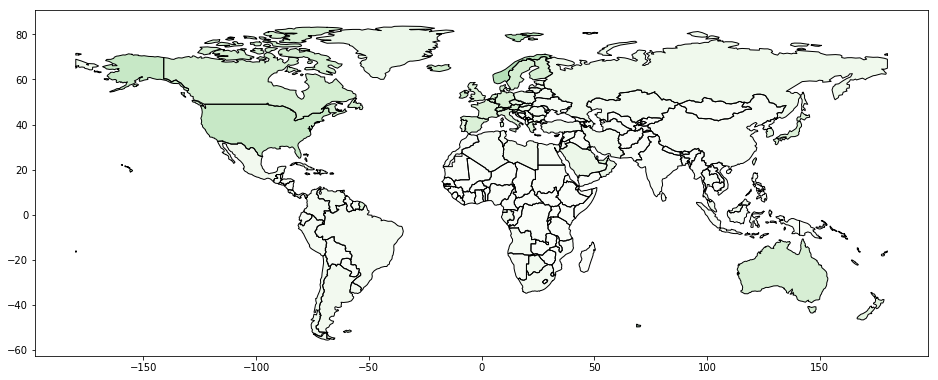

In [16]:
# What do the colours mean? no legend? no title?
world.plot(column='gdp_per_cap', cmap='Greens')

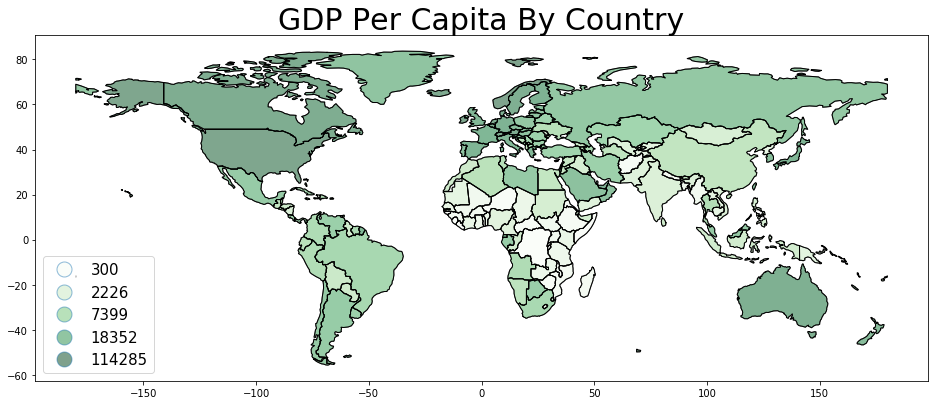

In [17]:
# Use our helper function to add legend and thicken colors
plot_geodataframe(world, column='gdp_per_cap', colormap='Greens', legend=True)
plt.title('GDP Per Capita By Country', fontsize=30)

In [18]:
# Merge data frames to get happiness data on to our dataset with map data
world_happiness_df = df.merge(world, left_on='Country', right_on='name', how='inner')

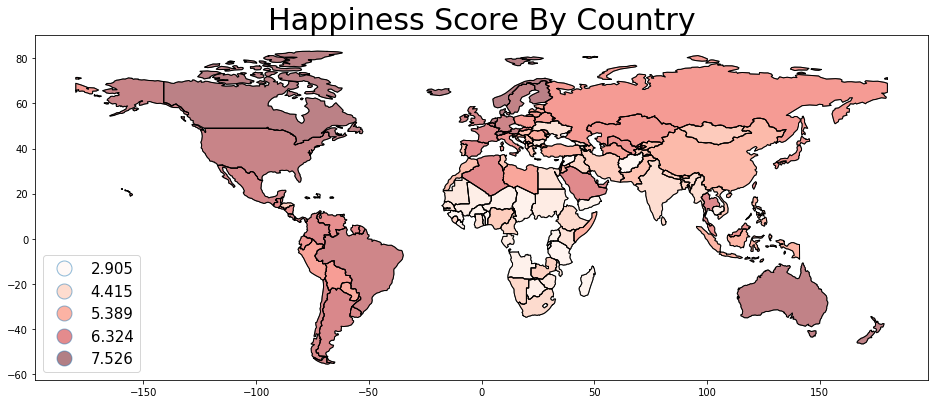

In [19]:
plot_geodataframe(world_happiness_df, column='Happiness Score', colormap='Reds', legend=True)
plt.title('Happiness Score By Country', fontsize=30)

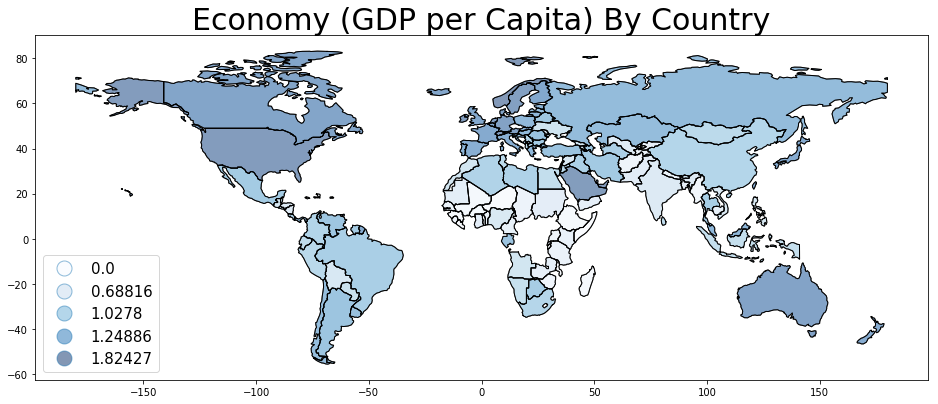

In [20]:
plot_geodataframe(world_happiness_df, column='Economy (GDP per Capita)', colormap='Blues', legend=True)
plt.title('Economy (GDP per Capita) Score By Country', fontsize=30)
plt.show()

<h2>Happiness vs GDP Scatterplots</h2>

In [21]:
bokeh_df = process_dataframe_for_bokeh(world_happiness_df)

In [22]:
hover = create_hover_tool()

p = figure(plot_width=600, plot_height=400, tools=[hover, 'pan' ,'box_zoom','reset', 'wheel_zoom'],
           title="Happiness vs GDP")
p.circle('Economy (GDP per Capita)', 'happiness_score', size=10, source=bokeh_df)
show(p)

In [23]:
plot_world_happiness_by_continent(world_happiness_df)

<h2>Happiness Grouped by Continent</h2>

In [24]:
# Group by continent and take the average score per continent
happiness_by_continent_df = world_happiness_df.groupby('continent')['Happiness Score'].mean().reset_index()

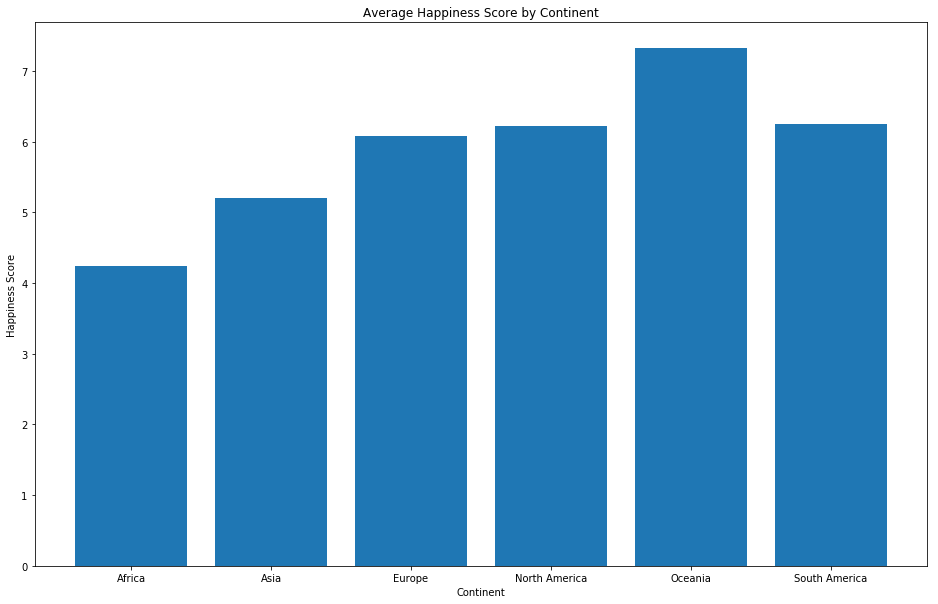

In [25]:
# create array of numbers from 0 to len(df) - 1
y_pos = np.arange(len(happiness_by_continent_df))
# plot scores at positions on plot
plt.bar(y_pos, happiness_by_continent_df['Happiness Score'])
# set tick values to the continent names
plt.xticks(y_pos, happiness_by_continent_df['continent'])
plt.ylabel('Happiness Score')
plt.xlabel('Continent')
plt.title('Average Happiness Score by Continent') 

In [26]:
happiness_scores = world_happiness_df['Happiness Score']
continents = world_happiness_df['continent']

In [27]:
score_by_continent = defaultdict(list)
for score, continent in zip(happiness_scores, continents):
    score_by_continent[continent].append(score)

In [28]:
set(continents)

{u'Africa', u'Asia', u'Europe', u'North America', u'Oceania', u'South America'}

In [29]:
keys = sorted([k for k in score_by_continent])
scores = [score_by_continent[k] for k in keys]

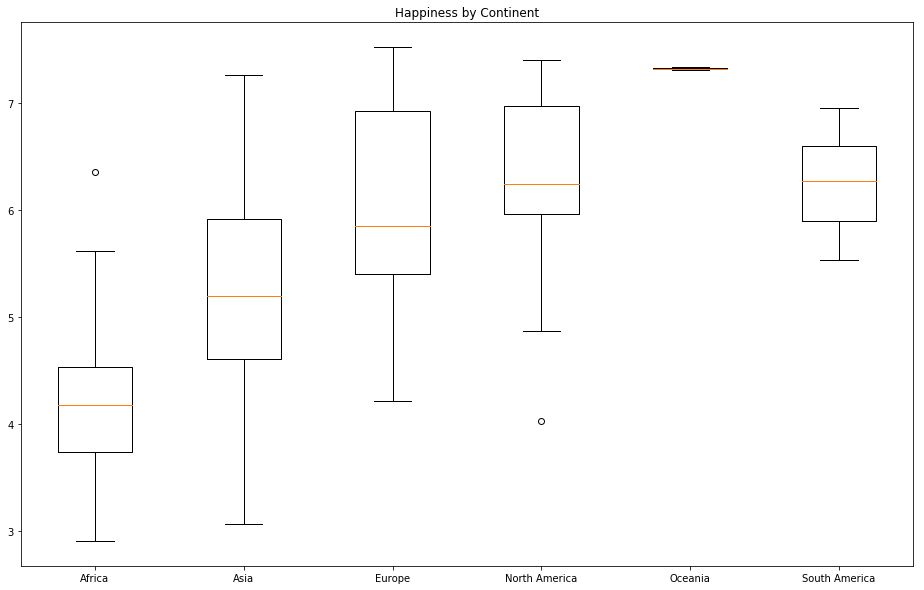

In [30]:
plt.boxplot(scores)
plt.xticks(np.arange(1, len(keys) + 1), keys)
plt.title('Happiness by Continent')
plt.show()